# find all of Katie's data

In [1]:
# this is an internal package I wrote for easy access to encode data 
from pybedtools import BedTool
import matplotlib.pyplot as plt
plt.style.use('seaborn-muted')
import sys
import pandas as pd
import numpy as np
master_df = pd.read_csv('encode_data.csv')
master_df['idr'] # these are all the IDR peaks!

0      /projects/ps-yeolab5/encode/EVN_eCLIP_analysis...
1      /projects/ps-yeolab5/encode/EVN_eCLIP_analysis...
2      /projects/ps-yeolab5/encode/EVN_eCLIP_analysis...
3      /projects/ps-yeolab5/encode/EVN_eCLIP_analysis...
4      /projects/ps-yeolab5/encode/EVN_eCLIP_analysis...
                             ...                        
330    /projects/ps-yeolab5/encore/processing/encore_...
331    /projects/ps-yeolab5/encore/processing/encore_...
332    /projects/ps-yeolab5/encore/processing/encore_...
333    /projects/ps-yeolab5/encore/processing/encore_...
334    /projects/ps-yeolab5/encore/processing/encore_...
Name: idr, Length: 335, dtype: object

## Calculate Jaccard for rG4

In [2]:
# to find what transcript those intersecting peaks are in:
# you need to load the trascript coordinates from gencode (i have it parsed already here)
transcripts = BedTool('/home/hsher/gencode_coords/gencode.v33.transcript.gff3')

def get_jaccard(bed1,bed2, return_transcript = False, transcripts = transcripts):
    '''
    input 2 bed files, return jaccard index to represent how they overlap
    if return_transcript is true, return BedTool object of transcript gff coords
    
    '''
    # select IDRs and G4 in UTR only
    
    
    intersect_peaks = bed1.intersect(bed2, s = True, u = True)
    intersect = len(intersect_peaks)
    not_one = len(bed2)-intersect
    not_two = len(bed1)-intersect
    
    jaccard = intersect/(intersect+not_one+not_two)
    
    #### return transcripts that has the intersecting peaks!
    if return_transcript:
        # find what transcript is
        

        # then, to find what transcripts the peaks are in (s = stranded, u = unique)
        transcripts_with_peaks = transcripts.intersect(intersect_peaks, s = True, u = True).saveas()

        return jaccard, transcripts_with_peaks
    else:
        
        return jaccard

## Let loop over all encode proteins!

In [3]:
utr = BedTool('/home/hsher/gencode_coords/gencode.v33.utr.gff3')

In [6]:
# find five prime and three prime utr
utr5=utr.filter(lambda x: x[2]=='five_prime_UTR').saveas()
utr3=utr.filter(lambda x: x[2]=='three_prime_UTR').saveas()

In [7]:
len(utr5), len(utr3)

(28811, 21598)

In [8]:
def region_specific_peaks(region, master_df = master_df):
    ''' find peaks in specific region'''
    n_peak = []
    region_peak_dict = {}
    for uid in master_df['uid']:
        try:
            peak = BedTool(master_df.loc[master_df['uid']==uid, 'idr'].iloc[0])
            region_peak = peak.intersect(region, s = True, u = True).saveas()
            n_peak.append([uid,len(region_peak)])
            region_peak_dict[uid] = region_peak
        except:
            pass
    
    # make stat
    stat = pd.DataFrame(n_peak, columns = ['uid', 'npeak'])
    return stat, region_peak_dict

In [10]:
# filter for those that have utr binding
utr5_stat, utr5_peak_dict = region_specific_peaks(utr5)

Text(0.5, 0, "# peak in 5' UTR ")

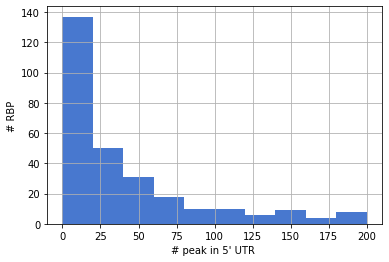

In [12]:
# see how many there are in 5 UTR
utr5_stat['npeak'].hist(range=(0,200))
plt.ylabel('# RBP')
plt.xlabel('# peak in 5\' UTR ')

In [13]:
# do the same for 3utr
utr3_stat, utr3_peak_dict = region_specific_peaks(utr3)

Text(0.5, 0, "# peak in 3' UTR ")

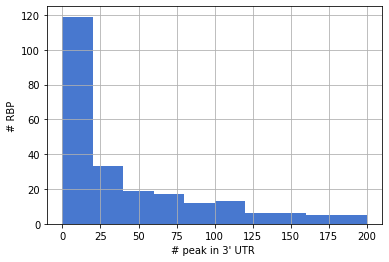

In [15]:
# see how many there are in 3 UTR
utr3_stat['npeak'].hist(range=(0,200))
plt.ylabel('# RBP')
plt.xlabel('# peak in 3\' UTR ')

In [17]:
import warnings
from itertools import combinations
len(list(combinations(utr3_stat.loc[utr3_stat['npeak']>50,'uid'], 2)))

13695

In [18]:
len(list(combinations(utr5_stat.loc[utr5_stat['npeak']>50,'uid'], 2)))

7021

# Physically overlapping RBPs in the 5UTR
- Hugo wants to know if PUM1 and PUM2 overlaps

In [28]:
def get_physical_overlap_jaccard(stat_df, peak_dict, n_peak_thres = 50):
    ''' compute jaccard distance by overlapping peaks,
    require at least `n_peak_thres` to do a overlap to avoid artifactual large jaccard indices
    stat_df: pd.DataFrame containing # of peaks for each uid
    peak_dict: dict, pointing uid -> BedTool object
    n_peak_thres: int, require each eCLIP to have at least n peaks to be considered
    
    '''
    jaccard_df = []
    for pairs in combinations(stat_df.loc[stat_df['npeak']>n_peak_thres,'uid'], 2):
        bed1 = peak_dict[pairs[0]]
        bed2 = peak_dict[pairs[1]]
        j = get_jaccard(bed1, bed2)
        jaccard_df.append([pairs[0], pairs[1], j])
    
    # convert to dataframe 
    df = pd.DataFrame(jaccard_df, columns = ['uid1', 'uid2', 'jaccard'])
    df['rbp1'] = df['uid1'].map(master_df.set_index('uid')['RBP'])
    df['rbp2'] = df['uid2'].map(master_df.set_index('uid')['RBP'])
    return df

In [30]:
utr5_jaccard=get_physical_overlap_jaccard(utr5_stat, utr5_peak_dict, n_peak_thres = 50)

,uid1,uid2,jaccard,rbp1,rbp2
6209,729,4002,0.000000,YBX3,FXR2
6099,719,4072,0.000000,PCBP1,UBCH7
1985,301,465,0.000000,SRSF1,UPF1
6100,719,4114,0.000000,PCBP1,PRPF39
1983,301,461,0.000000,SRSF1,LARP4
...,...,...,...,...,...
3761,492,4082,0.366667,DDX3X,EIF4E
5205,603,692,0.407583,DDX59,PCBP1
2642,350,4138,0.421350,DDX3X,EIF3A
693,236,237,0.458537,FMR1,FXR2


Text(0.5, 0, 'jaccard index (5UTR)')

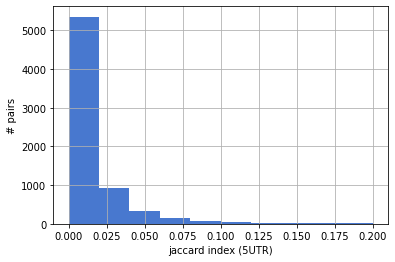

In [31]:
utr5_jaccard['jaccard'].hist(range = (0,0.2))
plt.ylabel('# pairs')
plt.xlabel('jaccard index (5UTR)')

In [35]:
# show top hits
utr5_jaccard.loc[utr5_jaccard['jaccard']>0.1].sort_values(by = 'jaccard')

,uid1,uid2,jaccard,rbp1,rbp2
3497,477,752,0.100082,NCBP2,PRPF4
3543,481,530,0.100154,DROSHA,RPS3
5210,603,729,0.100437,DDX59,YBX3
614,228,507,0.101307,SF3B4,SF3B4
5837,677,4138,0.101515,GEMIN5,EIF3A
...,...,...,...,...,...
3761,492,4082,0.366667,DDX3X,EIF4E
5205,603,692,0.407583,DDX59,PCBP1
2642,350,4138,0.421350,DDX3X,EIF3A
693,236,237,0.458537,FMR1,FXR2


In [36]:
utr5_jaccard.to_csv('utr5_jaccard.csv')

# Physically overlapping RBPs in the 3UTR

In [37]:
utr3_jaccard=get_physical_overlap_jaccard(utr3_stat, utr3_peak_dict, n_peak_thres = 50)

Text(0.5, 0, 'jaccard index (3UTR)')

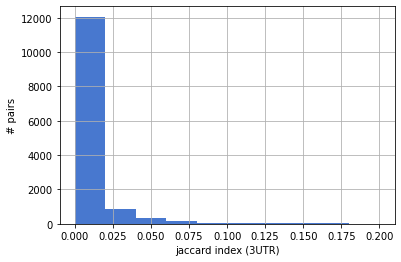

In [38]:
utr3_jaccard['jaccard'].hist(range = (0,0.2))
plt.ylabel('# pairs')
plt.xlabel('jaccard index (3UTR)')

In [39]:
utr3_jaccard.loc[utr3_jaccard['jaccard']>0.1].sort_values(by = 'jaccard')

,uid1,uid2,jaccard,rbp1,rbp2
7690,492,4138,0.100592,DDX3X,EIF3A
5218,345,558,0.100639,PCBP2,LARP4
13396,4081,4111,0.100694,APEX1,CTCF
5644,384,729,0.100894,GTF2F1,YBX3
10797,629,743,0.101449,UCHL5,ZNF800
...,...,...,...,...,...
2482,260,4014,0.509044,EIF4G2,TDP43
8871,543,655,0.560229,AGGF1,XPO5
9457,556,723reseq1,0.572327,CDC40,FTO
8890,543,723reseq1,0.622159,AGGF1,FTO


In [40]:
utr3_jaccard.to_csv('utr3_jaccard.csv')

## Do they correlate?

In [41]:
merged=utr5_jaccard.merge(utr3_jaccard, left_on = ['uid1', 'uid2'], right_on = ['uid1', 'uid2'], suffixes=('_utr5', '_utr3'))

In [47]:
merged['cell_line1']=merged['uid1'].map(master_df.set_index('uid')['Cell line'])
merged['cell_line2']=merged['uid2'].map(master_df.set_index('uid')['Cell line'])

<AxesSubplot:xlabel='jaccard_utr5', ylabel='jaccard_utr3'>

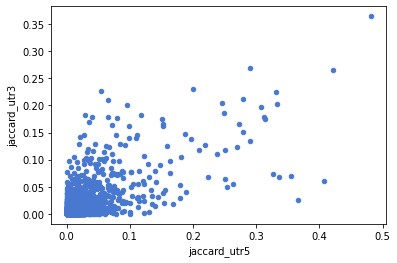

In [48]:
merged.loc[merged['cell_line1']==merged['cell_line2']].plot.scatter(x = 'jaccard_utr5', y = 'jaccard_utr3')

In [52]:
merged.loc[(merged['cell_line1']==merged['cell_line2'])&(merged['jaccard_utr5']>0.2)&(merged['jaccard_utr3']<0.2)]

,uid1,uid2,jaccard_utr5,rbp1_utr5,rbp2_utr5,jaccard_utr3,rbp1_utr3,rbp2_utr3,cell_line1,cell_line2
627,236,4002,0.223647,FMR1,FXR2,0.068807,FMR1,FXR2,K562,K562
633,236,4030,0.250929,FMR1,FMRP,0.118110,FMR1,FMRP,K562,K562
634,236,4036,0.269697,FMR1,FXR1,0.122807,FMR1,FXR1,K562,K562
838,275,342,0.289817,CSTF2T,GTF2F1,0.133700,CSTF2T,GTF2F1,K562,K562
1253,292,297,0.253898,CSTF2T,FAM120A,0.049089,CSTF2T,FAM120A,HepG2,HepG2
1261,292,384,0.262712,CSTF2T,GTF2F1,0.056093,CSTF2T,GTF2F1,HepG2,HepG2
1342,297,384,0.238095,FAM120A,GTF2F1,0.110215,FAM120A,GTF2F1,HepG2,HepG2
1401,297,4114,0.335664,FAM120A,PRPF39,0.068709,FAM120A,PRPF39,HepG2,HepG2
1408,297,4149,0.354717,FAM120A,PRPF39,0.070874,FAM120A,PRPF39,HepG2,HepG2
1696,326,719,0.210046,HNRNPK,PCBP1,0.117831,HNRNPK,PCBP1,K562,K562


In [53]:
merged.to_csv('35utr.sep.csv')

# Gene level interaction
- binding the same 3'UTR, but not on the same site
- binding the same 5'UTR, but not on the same site
- binding the same gene, one on 3' UTR, the other on 5' UTR

In [55]:
print(utr5_peak_dict['204'][0])

chr14	24146589	24146680	12.0935194992938	3.04795911589058	-



In [58]:
def find_gene_id(peak_dict):
    ''' return gene id for the peak it is in'''
    gene_dict = {}
    n_gene = []
    
    for key in peak_dict.keys():
        gene_id = set([t.attrs['gene_id'] for t in transcripts.intersect(peak_dict[key], s = True, u = True)])
        gene_dict[key] = gene_id
    return gene_dict
    

In [59]:
utr5_gene_id = find_gene_id(utr5_peak_dict)

In [61]:
utr3_gene_id = find_gene_id(utr3_peak_dict)

In [62]:
def jaccard_set(set1, set2):
    ''' return jaccard index given 2 sets'''
    intersection = len(set1.intersection(set2))
    union = (len(set1) + len(set2)) - intersection
    return float(intersection) / union


In [64]:
def get_gene_level_overlap_jaccard(stat_df, gene_dict, n_peak_thres = 50):
    ''' compute jaccard distance by overlapping Gene ids,
    require at least `n_peak_thres` to do a overlap to avoid artifactual large jaccard indices
    stat_df: pd.DataFrame containing # of peaks for each uid
    peak_dict: dict, pointing uid -> BedTool object
    n_peak_thres: int, require each eCLIP to have at least n peaks to be considered
    
    '''
    jaccard_df = []
    for pairs in combinations(stat_df.loc[stat_df['npeak']>n_peak_thres,'uid'], 2):
        genes1 = gene_dict[pairs[0]]
        genes2 = gene_dict[pairs[1]]
        j = jaccard_set(genes1, genes2)
        jaccard_df.append([pairs[0], pairs[1], j])
    
    # convert to dataframe 
    df = pd.DataFrame(jaccard_df, columns = ['uid1', 'uid2', 'jaccard'])
    df['rbp1'] = df['uid1'].map(master_df.set_index('uid')['RBP'])
    df['rbp2'] = df['uid2'].map(master_df.set_index('uid')['RBP'])
    return df

In [68]:
# gene level intersection for region-specific
utr5_gene_jaccard=get_gene_level_overlap_jaccard(utr5_stat, utr5_gene_id)
utr3_gene_jaccard=get_gene_level_overlap_jaccard(utr3_stat, utr3_gene_id)

In [120]:
utr5_gene_jaccard.to_csv('utr5.genelevel.jaccard.csv')
utr3_gene_jaccard.to_csv('utr3.genelevel.jaccard.csv')

In [74]:
# compare to physical intersection
merged_utr5=utr5_jaccard.merge(utr5_gene_jaccard, left_on = ['uid1', 'uid2'], right_on = ['uid1', 'uid2'], suffixes=('_physical', '_genelevel'))
merged_utr5['cell_line1']=merged['uid1'].map(master_df.set_index('uid')['Cell line'])
merged_utr5['cell_line2']=merged['uid2'].map(master_df.set_index('uid')['Cell line'])

Text(0.5, 1.0, 'UTR5')

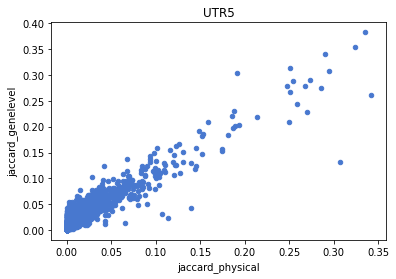

In [79]:
merged_utr5.loc[merged_utr5['cell_line1']==merged_utr5['cell_line2']].plot.scatter(x = 'jaccard_physical', y = 'jaccard_genelevel')
plt.title('UTR5')

In [77]:
# compare to physical intersection
merged_utr3=utr3_jaccard.merge(utr3_gene_jaccard, left_on = ['uid1', 'uid2'], right_on = ['uid1', 'uid2'], suffixes=('_physical', '_genelevel'))
merged_utr3['cell_line1']=merged['uid1'].map(master_df.set_index('uid')['Cell line'])
merged_utr3['cell_line2']=merged['uid2'].map(master_df.set_index('uid')['Cell line'])

Text(0.5, 1.0, 'UTR3')

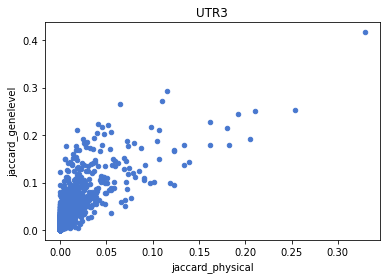

In [80]:
merged_utr3[merged_utr3['cell_line1']==merged_utr3['cell_line2']].plot.scatter(x = 'jaccard_physical', y = 'jaccard_genelevel')
plt.title('UTR3')

In [82]:
merged_utr3.loc[(merged_utr3['jaccard_genelevel']-merged_utr3['jaccard_physical']>0.1)&
                (merged_utr3['jaccard_genelevel']>0.2)&
                (merged_utr3['cell_line1']==merged_utr3['cell_line2'])]

,uid1,uid2,jaccard_physical,rbp1_physical,rbp2_physical,jaccard_genelevel,rbp1_genelevel,rbp2_genelevel,cell_line1,cell_line2
654,211,215,0.039510,IGF2BP3,TIA1,0.205327,IGF2BP3,TIA1,K562,K562
977,220,226,0.115782,IGF2BP1,IGF2BP2,0.293326,IGF2BP1,IGF2BP2,K562,K562
990,220,285,0.064491,IGF2BP1,TIA1,0.264416,IGF2BP1,TIA1,K562,K562
1013,220,441,0.040956,IGF2BP1,PUM2,0.222859,IGF2BP1,PUM2,K562,K562
1093,220,632x,0.054996,IGF2BP1,SUB1,0.207414,IGF2BP1,SUB1,K562,K562
1099,220,4044,0.017869,IGF2BP1,ELAVL1,0.210282,IGF2BP1,ELAVL1,K562,K562
1552,226,719,0.107063,IGF2BP2,PCBP1,0.211051,IGF2BP2,PCBP1,K562,K562
3111,279,285,0.044729,FAM120A,TIA1,0.216824,FAM120A,TIA1,HepG2,HepG2
3204,279,726,0.098085,FAM120A,UPF1,0.216864,FAM120A,UPF1,K562,K562
3421,285,441,0.051854,TIA1,PUM2,0.221717,TIA1,PUM2,K562,K562


In [100]:
def overlap_two_regions(region1_gene, region2_gene, stat1, stat2, reg1name='utr5', reg2name='utr3', n_peak_thres=50):
    ''' compute jaccard distance by overlapping Gene ids,
    require at least `n_peak_thres` to do a overlap to avoid artifactual large jaccard indices
    stat1, sata2: pd.DataFrame containing # of peaks for each uid
    region1_gene, region2_gene: dict, pointing uid -> set (gene id list) object
    n_peak_thres: int, require each eCLIP to have at least n peaks to be considered
    
    '''
    
    reg1_ids=stat1.loc[stat1['npeak']>n_peak_thres,'uid']
    reg2_ids=stat2.loc[stat2['npeak']>n_peak_thres,'uid']
    
    jaccard_df = []
    for id1 in reg1_ids:
        for id2 in reg2_ids:
            
   
            genes1 = region1_gene[id1]
            genes2 = region2_gene[id2]
            j = jaccard_set(genes1, genes2)
            jaccard_df.append([id1, id2, j])
    
    # convert to dataframe 
    df = pd.DataFrame(jaccard_df, columns = [f'uid_{reg1name}', f'uid_{reg2name}', 'jaccard_across'])
    df[f'rbp_{reg1name}'] = df[f'uid_{reg1name}'].map(master_df.set_index('uid')['RBP'])
    df[f'rbp_{reg2name}'] = df[f'uid_{reg2name}'].map(master_df.set_index('uid')['RBP'])
    return df

In [101]:
utr5_utr3_gene_jaccard = overlap_two_regions(utr5_gene_id, utr3_gene_id, utr5_stat, utr3_stat)

In [102]:
utr5_utr3_gene_jaccard.head()

,uid_utr5,uid_utr3,jaccard_across,rbp_utr5,rbp_utr3
0,204,203,0.000000,RBFOX2,HNRNPC
1,204,204,0.000000,RBFOX2,RBFOX2
2,204,205,0.001316,RBFOX2,IGF2BP1
3,204,206,0.006993,RBFOX2,HNRNPK
4,204,211,0.003509,RBFOX2,IGF2BP3


In [119]:
utr5_utr3_gene_jaccard.to_csv('crossregion.genelevel.csv')

In [103]:
megamerge=utr5_utr3_gene_jaccard.merge(merged_utr5, 
                             left_on = ['uid_utr5', 'uid_utr3'], 
                             right_on = ['uid1', 'uid2'], 
                             suffixes=('_across', '_utr5')).merge(
    merged_utr3, 
                             left_on = ['uid_utr5', 'uid_utr3'], 
                             right_on = ['uid1', 'uid2'], 
                             suffixes=('', '_utr3')
)


In [104]:
megamerge=megamerge()

Index(['uid_utr5', 'uid_utr3', 'jaccard_across', 'rbp_utr5', 'rbp_utr3',
       'uid1', 'uid2', 'jaccard_physical', 'rbp1_physical', 'rbp2_physical',
       'jaccard_genelevel', 'rbp1_genelevel', 'rbp2_genelevel', 'cell_line1',
       'cell_line2', 'uid1_utr3', 'uid2_utr3', 'jaccard_physical_utr3',
       'rbp1_physical_utr3', 'rbp2_physical_utr3', 'jaccard_genelevel_utr3',
       'rbp1_genelevel_utr3', 'rbp2_genelevel_utr3', 'cell_line1_utr3',
       'cell_line2_utr3'],
      dtype='object')

Text(0, 0.5, 'jaccard_genelevel_utr5')

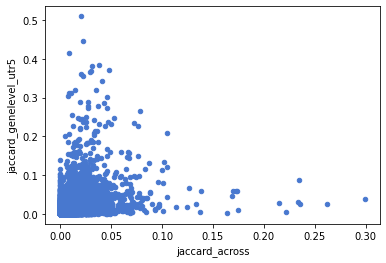

In [110]:
megamerge.plot.scatter(x='jaccard_across', y = 'jaccard_genelevel')
plt.ylabel('jaccard_genelevel_utr5')

Text(0, 0.5, '# pairs')

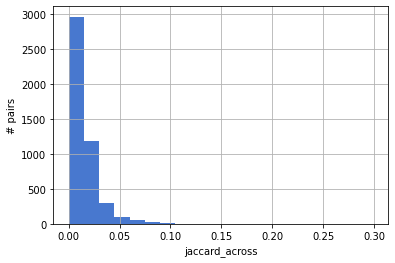

In [113]:
megamerge['jaccard_across'].hist(bins = 20)
plt.xlabel('jaccard_across')
plt.ylabel('# pairs')

In [114]:
megamerge['cell_line1']=megamerge['uid1'].map(master_df.set_index('uid')['Cell line'])
megamerge['cell_line2']=megamerge['uid2'].map(master_df.set_index('uid')['Cell line'])

In [116]:
megamerge.loc[(megamerge['jaccard_across']>0.1)&
                (megamerge['cell_line1']==megamerge['cell_line2'])].sort_values(by = 'jaccard_across')

,uid_utr5,uid_utr3,jaccard_across,rbp_utr5,rbp_utr3,uid1,uid2,jaccard_physical,rbp1_physical,rbp2_physical,...,uid1_utr3,uid2_utr3,jaccard_physical_utr3,rbp1_physical_utr3,rbp2_physical_utr3,jaccard_genelevel_utr3,rbp1_genelevel_utr3,rbp2_genelevel_utr3,cell_line1_utr3,cell_line2_utr3
3931,677,4044,0.100719,GEMIN5,ELAVL1,677,4044,0.003922,GEMIN5,ELAVL1,...,677,4044,0.001688,GEMIN5,ELAVL1,0.009044,GEMIN5,ELAVL1,NaN,NaN
2977,530,374x4000fix,0.100787,RPS3,APOBEC3C,530,374x4000fix,0.049020,RPS3,APOBEC3C,...,530,374x4000fix,0.078189,RPS3,APOBEC3C,0.127036,RPS3,APOBEC3C,NaN,NaN
2386,481,530,0.102215,DROSHA,RPS3,481,530,0.100154,DROSHA,RPS3,...,481,530,0.002907,DROSHA,RPS3,0.013115,DROSHA,RPS3,NaN,NaN
2101,406,461,0.104575,PABPC4,LARP4,406,461,0.250000,PABPC4,LARP4,...,406,461,0.065229,PABPC4,LARP4,0.067482,PABPC4,LARP4,NaN,NaN
3024,540,692,0.104704,RPS3,PCBP1,540,692,0.032389,RPS3,PCBP1,...,540,692,0.057718,RPS3,PCBP1,0.169492,RPS3,PCBP1,NaN,NaN
3667,628,643,0.104762,GRWD1,BCLAF1,628,643,0.078591,GRWD1,BCLAF1,...,628,643,0.145174,GRWD1,BCLAF1,0.205479,GRWD1,BCLAF1,NaN,NaN
1906,350,577,0.114072,DDX3X,DDX6,350,577,0.014072,DDX3X,DDX6,...,350,577,0.000000,DDX3X,DDX6,0.012731,DDX3X,DDX6,NaN,NaN
2551,492,632x,0.124124,DDX3X,SUB1,492,632x,0.009570,DDX3X,SUB1,...,492,632x,0.000866,DDX3X,SUB1,0.013728,DDX3X,SUB1,NaN,NaN
3008,540,558,0.126602,RPS3,LARP4,540,558,0.040764,RPS3,LARP4,...,540,558,0.056447,RPS3,LARP4,0.135317,RPS3,LARP4,NaN,NaN
3927,677,374x4000fix,0.133333,GEMIN5,APOBEC3C,677,374x4000fix,0.019940,GEMIN5,APOBEC3C,...,677,374x4000fix,0.014331,GEMIN5,APOBEC3C,0.042910,GEMIN5,APOBEC3C,NaN,NaN
